## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open("/content/complaints-2021-05-14_08_16.json")
# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [4]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
#Assign new column names
df.rename(columns={'_index': 'index', '_type': 'type','_id': 'id', '_score': 'score',
                   '_source.tags': 'tags', '_source.zip_code': 'zip_code','_source.complaint_id': 'complaint_id',
                   '_source.issue': 'issue','_source.date_received': 'date_received',
                   '_source.state': 'state','_source.consumer_disputed': 'consumer_disputed',
                  '_source.product': 'product','_source.company_response': 'company_response',
                  '_source.company': 'company','_source.submitted_via': 'submitted_via',
                  '_source.date_sent_to_company': 'date_sent_to_company',
                  '_source.company_public_response': 'company_public_response',
                  '_source.sub_product': 'sub_product','_source.timely': 'timely',
                  '_source.complaint_what_happened': 'complaint_what_happened',
                  '_source.sub_issue': 'sub_issue','_source.consumer_consent_provided': 'consumer_consent_provided',}, inplace=True)


In [6]:
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [7]:
df.head(10)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [8]:
df['complaint_what_happened'].isna().sum()

0

In [9]:
(df['complaint_what_happened']=='').sum()

57241

In [10]:
#Assign nan in place of blanks in the complaints column
df = df.replace(r'^\s*$', np.NaN, regex=True)


In [11]:
df['complaint_what_happened'].isna().sum()

57241

In [12]:
(df['complaint_what_happened']=='').sum()

0

In [13]:
df['complaint_what_happened']

,complaint_what_happened
0,NaN
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN
4,NaN
...,...
78308,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


In [14]:
df.shape

(78313, 22)

In [15]:
#Remove all rows where complaints column is nan
df=df[~df['complaint_what_happened'].isna()]

In [16]:
df.reset_index(drop=True, inplace=True)

In [17]:
df.shape

(21072, 22)

In [18]:
df['complaint_what_happened'][df['complaint_what_happened'].str.contains('\[', regex= True, na=False)]

,complaint_what_happened
131,"RE : Complaint Against JP Morgan Chase, XXXX H..."
165,I am responding to your contact about a debt y...
395,Chase Card Address : XXXX XXXX XXXX City/ Stat...
463,onXXXX XXXX odf XXXX Chase decided to tell the...
630,We posted item [ s ] for sale on XXXX XXXX an...
...,...
20454,XXXX XXXX commits FRAUD as charging customers ...
20482,"Time of Applicable Cases : Approximately, XX/X..."
20726,"Hi, As a loyal and long time customer of such ..."
20786,I left XXXX XXXX at XXXX on Thursday XX/XX/XXX...


In [19]:
df['complaint_what_happened'].head()

,complaint_what_happened
0,Good morning my name is XXXX XXXX and I apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,Chase Card was reported on XX/XX/2019. However...
3,"On XX/XX/2018, while trying to book a XXXX XX..."
4,my grand son give me check for {$1600.00} i de...


In [20]:
df['complaint_what_happened']=df['complaint_what_happened'].str.lower()
df['complaint_what_happened'].head()

,complaint_what_happened
0,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in xx/xx/2018 and...
2,chase card was reported on xx/xx/2019. however...
3,"on xx/xx/2018, while trying to book a xxxx xx..."
4,my grand son give me check for {$1600.00} i de...


In [21]:
##'xx' and digits are removed.
df['complaint_what_happened'].replace(to_replace={'xx','\d'}, value='', regex=True, inplace=True)

In [22]:
df['complaint_what_happened'].head()

,complaint_what_happened
0,good morning my name is and i appreciate it ...
1,i upgraded my card in // and was told by the...
2,"chase card was reported on //. however, fraudu..."
3,"on //, while trying to book a ticket, i ca..."
4,my grand son give me check for {$.} i deposit ...


In [23]:
##remove text enclosed in square brackets
df['complaint_what_happened'].replace(to_replace={'[\[].*?[\]]'}, value='', regex=True, inplace=True)

In [24]:
df['complaint_what_happened'].iloc[630]

'we posted item  for sale on    and other websites. someone interested in buying the same. we have told that it costs {$.} and transfer the same to our account. i have shared email id of my bank account. i have told that item will be shipped after receiving the amount. they have called nextday and told that by mistake t they transferred  instead of  on // i have checked my bank account and i can see amount for {$.}. i have decided to send money back and took his email id. i have transferred the money of {$.} ( using  through    ). they told that it went to their old/closed account and they said that have called  and sent money back to my account. i have checked my bank account and i saw credit of {$.}. he asked me to transfer to his other email id since first transfer didnt work. i did the same. second time he told money didnt go through since his account locked due to low balance. he told that he called  and cancel the same. i saw second credit of {$.}. he asked me to transfer {$.} th

In [25]:
##replace any non-word characters (punctuation, symbols, spaces) or underscores
df['complaint_what_happened'].replace(to_replace={'\W+|_'}, value=' ', regex=True, inplace=True)

In [26]:
df['complaint_what_happened'].head()

,complaint_what_happened
0,good morning my name is and i appreciate it if...
1,i upgraded my card in and was told by the agen...
2,chase card was reported on however fraudulent ...
3,on while trying to book a ticket i came across...
4,my grand son give me check for i deposit it in...


In [27]:
df['complaint_what_happened'].iloc[630]

'we posted item for sale on and other websites someone interested in buying the same we have told that it costs and transfer the same to our account i have shared email id of my bank account i have told that item will be shipped after receiving the amount they have called nextday and told that by mistake t they transferred instead of on i have checked my bank account and i can see amount for i have decided to send money back and took his email id i have transferred the money of using through they told that it went to their old closed account and they said that have called and sent money back to my account i have checked my bank account and i saw credit of he asked me to transfer to his other email id since first transfer didnt work i did the same second time he told money didnt go through since his account locked due to low balance he told that he called and cancel the same i saw second credit of he asked me to transfer this time to his sister account i tried to transfer the same from 

In [28]:
df['complaint_what_happened'].head()

,complaint_what_happened
0,good morning my name is and i appreciate it if...
1,i upgraded my card in and was told by the agen...
2,chase card was reported on however fraudulent ...
3,on while trying to book a ticket i came across...
4,my grand son give me check for i deposit it in...


In [29]:
df['complaint_what_happened'].iloc[0]

'good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help '

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [30]:

# Function to Lemmatize the texts
def lem_txt(data: str) -> str:
    """
    Lemmatizes the input text using spaCy and returns the lemmatized version as a string.

    Args:
    - data (str): The input text to be lemmatized.

    Returns:
    - str: The lemmatized text with tokens joined by spaces.
    """
    if not isinstance(data, str):
        raise ValueError("Input must be a string.")

    # Process the text with spaCy
    document = nlp(data)

    # Return lemmatized tokens joined by a space
    return " ".join([token.lemma_ for token in document])



In [31]:
# Add a column for lemmatized complaints to the dataframe
df["lemma_complaints"] = df.apply(lambda x: lem_txt(x['complaint_what_happened']), axis=1)

# View the first few rows of the dataframe
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemma_complaints
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if...,Didn't receive enough information to verify debt,Consent provided,good morning my name be and I appreciate it if...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agen...,Problem with rewards from credit card,Consent provided,I upgrade my card in and be tell by the agent ...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent app...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across...,Information belongs to someone else,Consent provided,on while try to book a ticket I come across an...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it int...


In [32]:
# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemma_complaints
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if...,Didn't receive enough information to verify debt,Consent provided,good morning my name be and I appreciate it if...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agen...,Problem with rewards from credit card,Consent provided,I upgrade my card in and be tell by the agent ...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent app...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across...,Information belongs to someone else,Consent provided,on while try to book a ticket I come across an...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it int...


In [123]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened','lemma_complaints']]

In [124]:
df_clean

,complaint_what_happened,lemma_complaints
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...


In [125]:
#Write your function to extract the POS tags

from textblob import TextBlob

# Function to extract POS tags
def pos_tag(text: str) -> list:
    """
    Extracts part-of-speech tags from the input text.

    Args:
    - text (str): The input text to analyze.

    Returns:
    - list: A list of tuples containing (word, POS tag).
    """
    # Create a TextBlob object
    blob = TextBlob(text)

    # Return the list of (word, tag) tuples
    return blob.tags


In [36]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [126]:


# Make sure to work with a copy of the DataFrame if needed
df_clean = df_clean.copy()

# Function to filter lemmatized words by POS tag
def filter_nouns(text: str) -> str:
    # Extract POS tags from the lemmatized text
    pos_tags = pos_tag(text)

    # Filter for singular nouns (NN) and join them back into a string
    return ' '.join([word for word, tag in pos_tags if tag == 'NN'])

# Assuming the lemmatized text is in a column named 'lemma_complaints'
df_clean["complaint_POS_removed"] = df_clean["lemma_complaints"].apply(filter_nouns)

# View the updated DataFrame
df_clean.head()



,complaint_what_happened,lemma_complaints,complaint_POS_removed
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...


In [127]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemma_complaints,complaint_POS_removed
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,wednesday credit card provider claim purchase ...
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [128]:
# Calculate the character lengths of each entry in the 'POS_complaint_singular' column
charcter_len = [len(x) for x in df_clean['complaint_POS_removed']]

# Display the first 10 character lengths
charcter_len[:10]


[159, 91, 74, 419, 161, 7, 630, 605, 1161, 51]

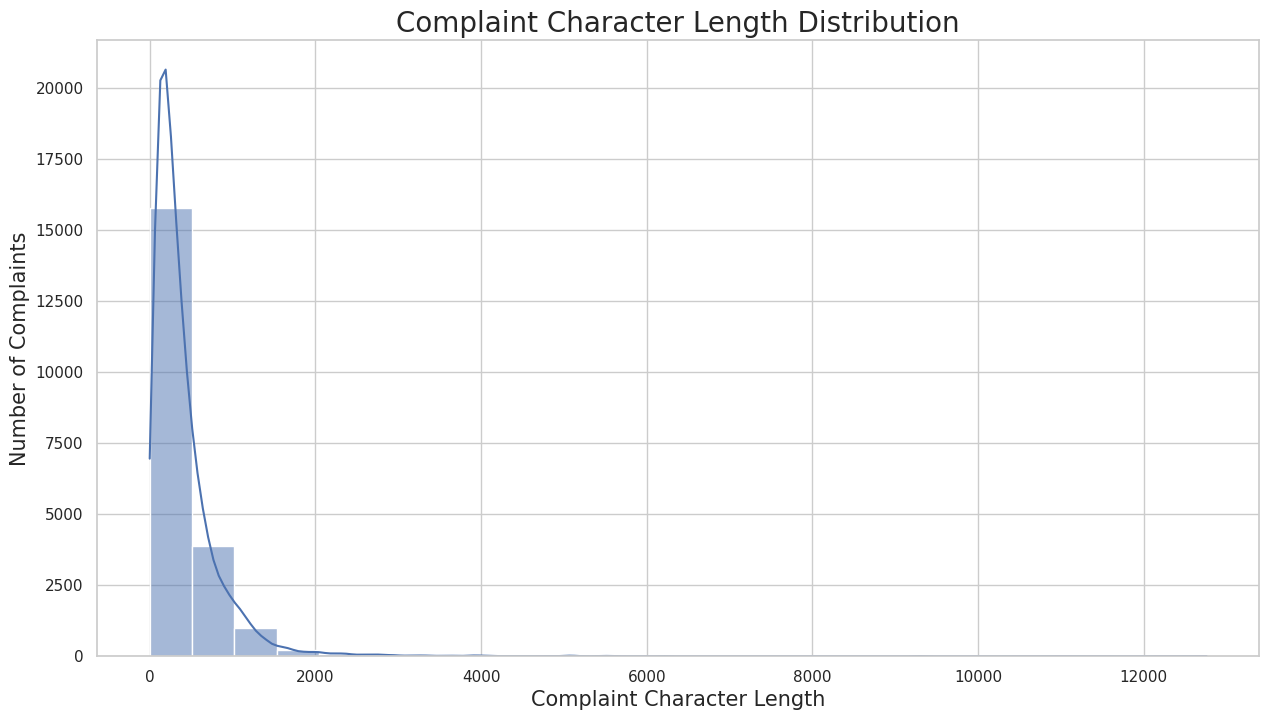

In [129]:
# Write your code here to visualise the data according to the 'Complaint' character length


# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with specified size
plt.figure(figsize=[15, 8])

# Create a histogram to visualize the distribution of character lengths
sns.histplot(data=charcter_len, bins=25, kde=True)  # Added kde=True for a density curve

# Add titles and labels
plt.title('Complaint Character Length Distribution', fontsize=20)
plt.xlabel('Complaint Character Length', fontsize=15)
plt.ylabel('Number of Complaints', fontsize=15)

# Show the plot
plt.show()


In [130]:
from wordcloud import WordCloud, STOPWORDS

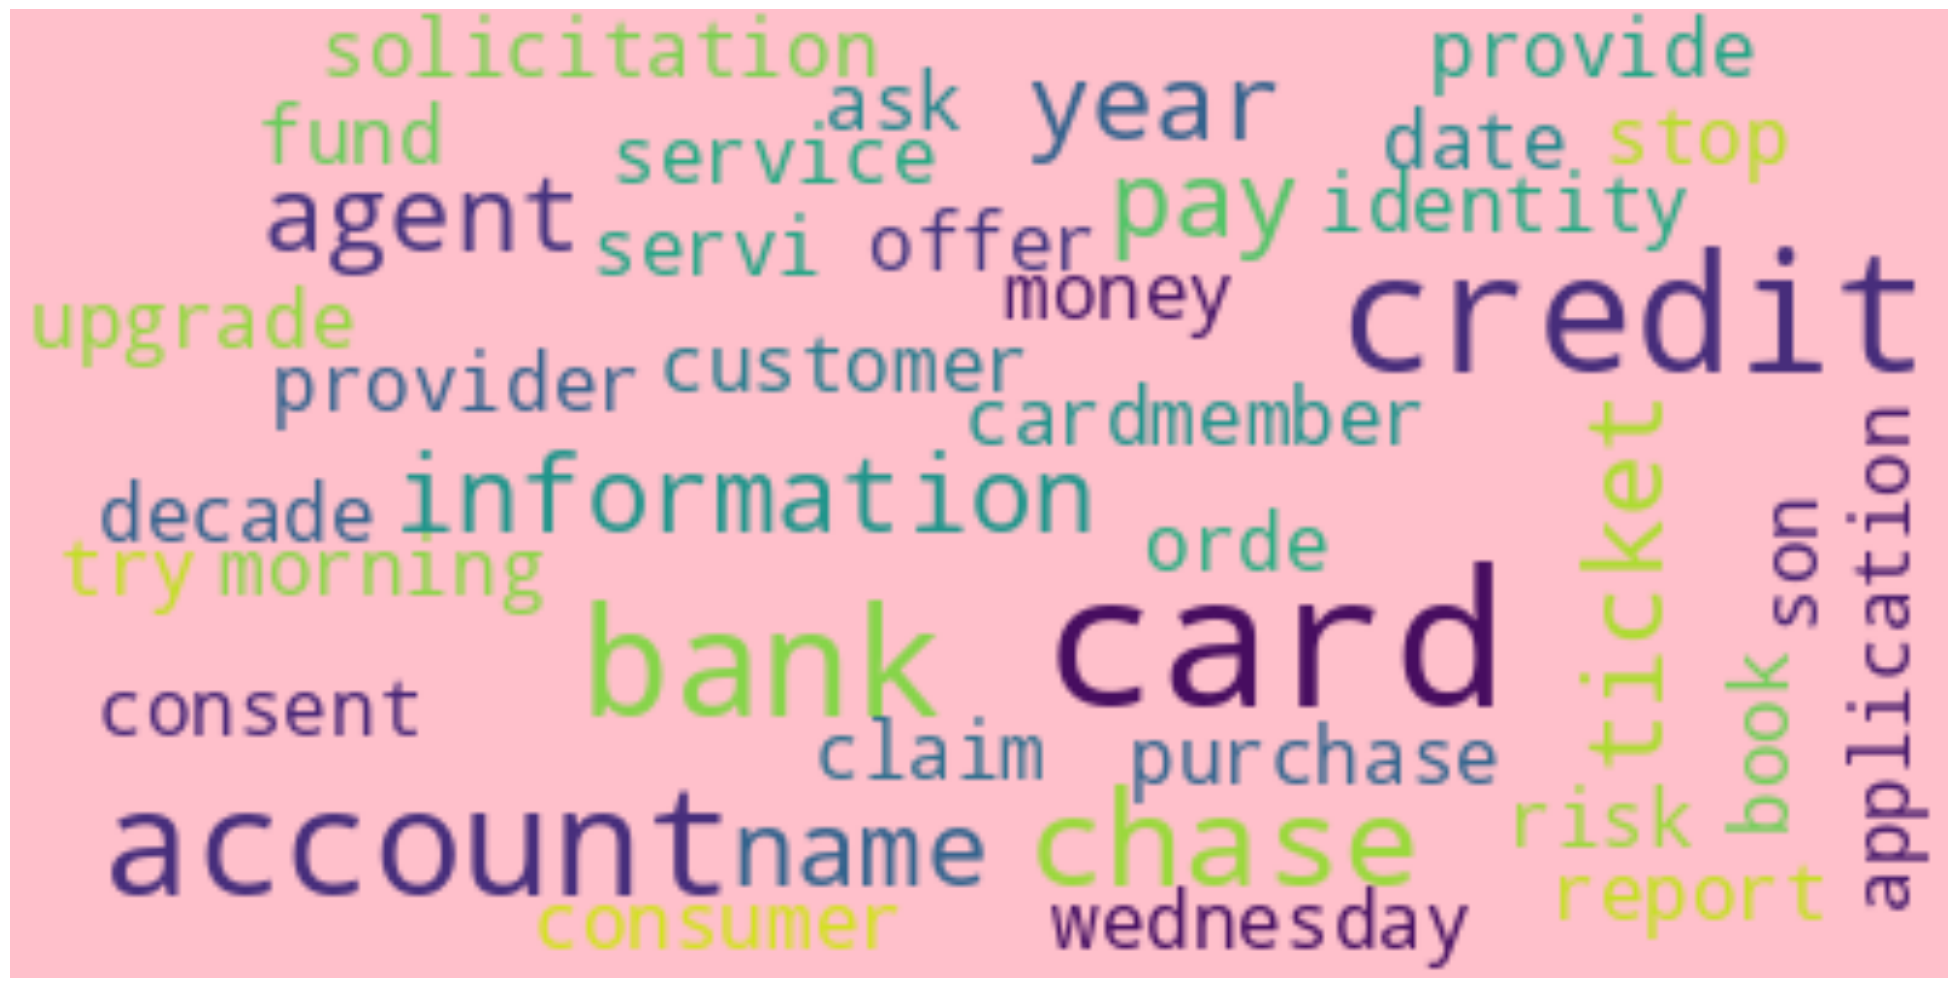

In [131]:


# Set of stopwords to remove common words
stop_words = set(STOPWORDS)

# Generating the word cloud using the 'complaint_POS_removed' column
word_cloud = WordCloud(
    background_color='pink',      # Background color of the word cloud
    stopwords=stop_words,         # Stopwords to exclude from the word cloud
    max_font_size=40,             # Maximum font size
    max_words=40,                 # Limit to top 40 most frequent words
    random_state=40               # For reproducibility of the results
).generate(str(df_clean['complaint_POS_removed']))

# Plot the word cloud
fig = plt.figure(figsize=(25, 20))  # Set the figure size
plt.imshow(word_cloud, interpolation='bilinear')  # Render the word cloud
plt.axis('off')  # Hide the axis
plt.show()  # Display the word cloud


In [132]:
#Removing -PRON- from the text corpus

df_clean = df_clean.copy()

# Remove '-PRON-' from the 'complaint_POS_removed' column and assign it to 'Complaint_clean'
df_clean.loc[:, 'Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '', regex=False)


In [133]:
df_clean.shape

(21072, 4)

#### Find the top 40 words by frequency among all the articles after processing the text.

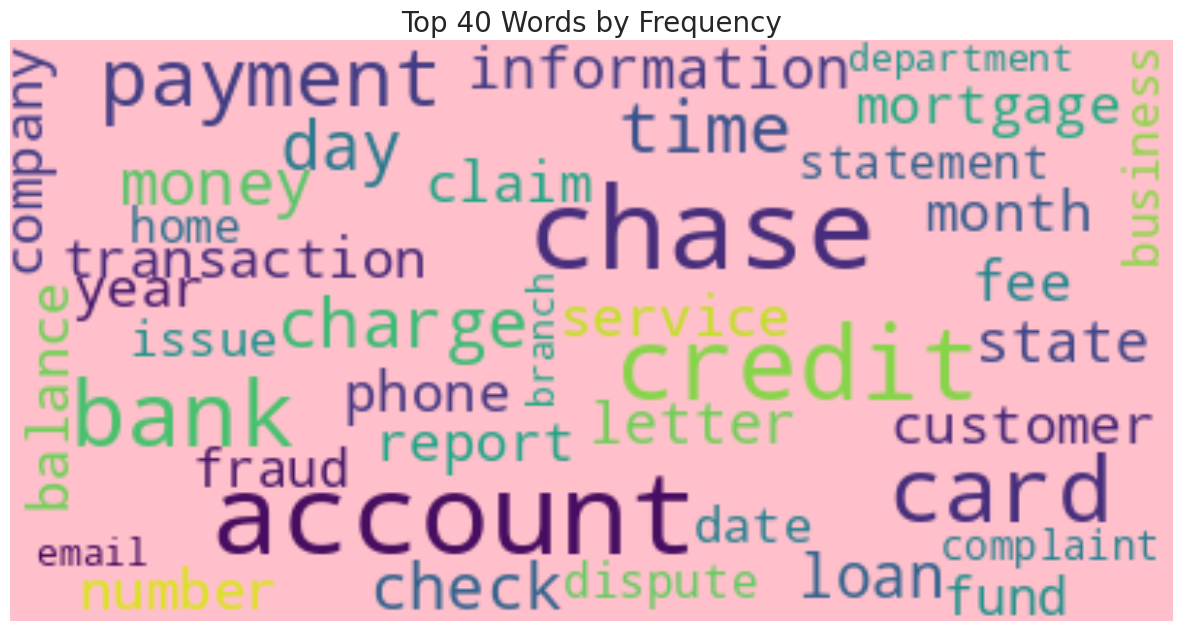

In [134]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


# Function to get the top N words by frequency
def get_top_words(text, n=40):
    vectorizer = CountVectorizer(stop_words='english')
    bag_of_words = vectorizer.fit_transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return dict(word_freq[:n])  # Return top N words as a dictionary

# Get the top 40 words from the cleaned data
top_words = get_top_words(df_clean['complaint_POS_removed'].tolist(), n=40)

# Create a word cloud from the top words
word_cloud = WordCloud(
    background_color='pink',
    stopwords=STOPWORDS,
    max_font_size=40,
    max_words=40,
    random_state=40
).generate_from_frequencies(top_words)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Top 40 Words by Frequency', fontsize=20)
plt.show()


In [135]:
#Removing -PRON- from the text corpus

df_clean.loc[:, 'Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '', regex=False)

# Optionally, strip any leading or trailing whitespace
df_clean.loc[:, 'Complaint_clean'] = df_clean['Complaint_clean'].str.strip()

# View the updated DataFrame
df_clean.head()


,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


In [136]:
df_clean

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,wednesday credit card provider claim purchase ...,wednesday credit card provider claim purchase ...
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...,credit yrs credit card chase freedom problem b...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [137]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).


# Function to get the top N unigram frequencies
def get_top30_unigram(text, n=30):
    """
    Get the top N unigrams by frequency from the input text.

    Args:
    - text (list of str): The input text data (e.g., complaints).
    - n (int): Number of top unigrams to return (default is 30).

    Returns:
    - list of tuples: Top N unigrams with their frequencies.
    """
    vectorizer = CountVectorizer(stop_words='english')  # Initialize CountVectorizer
    bag_of_words = vectorizer.fit_transform(text)        # Create the bag-of-words model
    sum_of_words = bag_of_words.sum(axis=0)              # Sum the word counts
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)  # Sort by frequency
    return word_freq[:n]  # Return the top N unigrams

# Example usage with the cleaned DataFrame
top_30_unigrams = get_top30_unigram(df_clean['complaint_POS_removed'].tolist(), n=30)

# Display the top 30 unigrams
for word, freq in top_30_unigrams:
    print(f"{word}: {freq}")


account: 47583
chase: 46918
credit: 34314
card: 29281
bank: 28533
payment: 21368
time: 16310
charge: 15196
day: 13333
check: 12311
money: 12005
loan: 11078
letter: 9724
state: 9723
information: 9684
report: 9030
transaction: 8690
fee: 8678
number: 8668
month: 8629
year: 8484
mortgage: 8243
customer: 8209
claim: 7865
service: 7769
balance: 7754
phone: 7748
company: 7659
fraud: 7204
fund: 7015


In [138]:
#Print the top 10 words in the unigram frequency


# Get the top 30 words from the cleaned complaints
top_30_words = get_top30_unigram(df_clean['Complaint_clean'].values.astype('U'), n=30)

# Create a DataFrame for the top words
df_unigram = pd.DataFrame(top_30_words, columns=['unigram', 'count'])

# Print the top 10 words
print(df_unigram.head(10))


   unigram  count
0  account  47583
1    chase  46918
2   credit  34314
3     card  29281
4     bank  28533
5  payment  21368
6     time  16310
7   charge  15196
8      day  13333
9    check  12311


<ipython-input-139-abd942fd894a>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




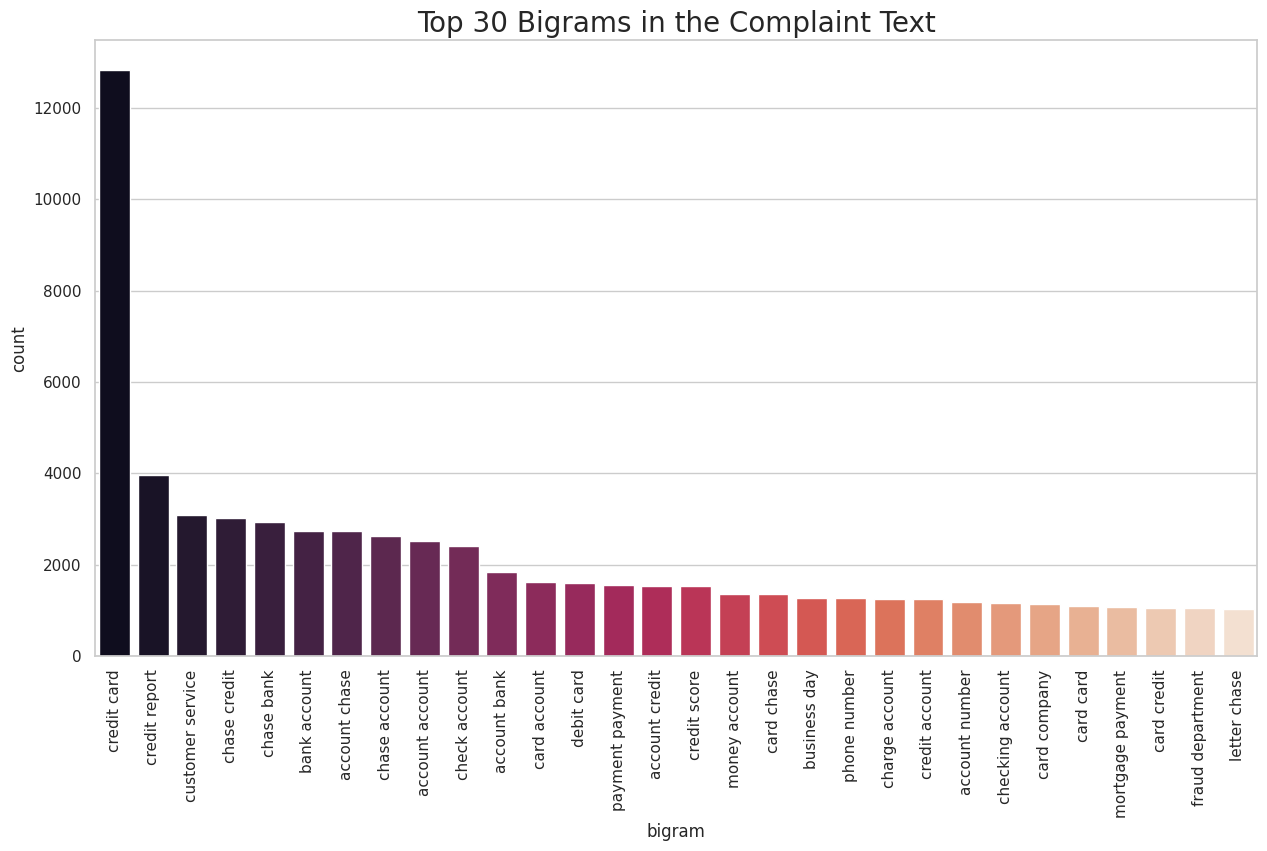

In [139]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get the top N bigrams by frequency
def get_top30_bigrams(text, n=30):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')  # Set ngram_range for bigrams
    bag_of_words = vectorizer.fit_transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]  # Return top N bigrams as a list of tuples

# Get the top 30 bigrams from the cleaned data
top_30_bigrams = get_top30_bigrams(df_clean['Complaint_clean'].values.astype('U'), n=30)

# Create a DataFrame for the top bigrams
df_bigram = pd.DataFrame(top_30_bigrams, columns=['bigram', 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(15, 8))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="rocket")
plt.xticks(rotation=90)
plt.title("Top 30 Bigrams in the Complaint Text", fontsize=20)
plt.show()


In [140]:
#Print the top 10 words in the bigram frequency

print(df_bigram.head(10))


             bigram  count
0       credit card  12835
1     credit report   3975
2  customer service   3092
3      chase credit   3020
4        chase bank   2945
5      bank account   2751
6     account chase   2730
7     chase account   2621
8   account account   2518
9     check account   2407


In [141]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


# Function to get the top N trigrams by frequency
def get_top30_trigrams(text, n=30):
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')  # Set ngram_range for trigrams
    bag_of_words = vectorizer.fit_transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]  # Return top N trigrams as a list of tuples

# Get the top 30 trigrams from the cleaned data
top_30_trigrams = get_top30_trigrams(df_clean['Complaint_clean'].values.astype('U'), n=30)

# Create a DataFrame for the top trigrams
df_trigram = pd.DataFrame(top_30_trigrams, columns=['trigram', 'count'])




In [142]:
#Print the top 10 words in the trigram frequency
# Print the top 10 trigrams
print("Top 10 Trigrams:")
print(df_trigram.head(10))

Top 10 Trigrams:
                   trigram  count
0        chase credit card   2109
1      credit card account   1033
2      credit card company   1003
3        credit card chase    670
4       credit card credit    531
5    inquiry credit report    485
6       charge credit card    433
7      account credit card    413
8         card credit card    394
9  credit reporting agency    388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [54]:
# removed already
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [143]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,wednesday credit card provider claim purchase ...,wednesday credit card provider claim purchase ...
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...,credit yrs credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [144]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [145]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix=tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [146]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [147]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [148]:
nmf_model.fit(doc_term_matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Number of features:", len(feature_names))

Number of features: 6878


In [149]:

topic_single = nmf_model.components_[0]
top_word_index = topic_single.argsort()[-10:]  # Get the indices of the top 10 words

# Print the top words for the first topic
for index in top_word_index:
    print(tfidf_vectorizer.get_feature_names_out()[index])  # Use the instance method


number
day
branch
deposit
chase
fund
money
check
bank
account


In [150]:
#Print the Top15 words for each of the topics
# Loop through each topic in the NMF model
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    top_word_indices = topic.argsort()[-15:]  # Get the indices of the top 15 words
    # Print the top words for the current topic
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in top_word_indices])
    print('\n')


TOP 15 WORDS FOR TOPIC #0
['transfer', 'customer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['year', 'mortgage', 'chase', 'account', 'credit', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [151]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Transform the document-term matrix to get topic distributions
topic_result = nmf_model.transform(doc_term_matrix)

# View the topic distribution for the first document
print("Topic distribution for the first document (rounded):", topic_result[0].round(2))

# Find the dominant topic for the first document
dominant_topic_first_doc = topic_result[0].argmax()
print("Dominant topic for the first document:", dominant_topic_first_doc)

# Find the dominant topic for all documents
dominant_topics_all_docs = topic_result.argmax(axis=1)

# Optionally, print the dominant topics for the first few documents
print("Dominant topics for the first 10 documents:", dominant_topics_all_docs[:10])



Topic distribution for the first document (rounded): [0.02 0.01 0.01 0.01 0.02]
Dominant topic for the first document: 0
Dominant topics for the first 10 documents: [0 1 1 1 0 1 0 2 3 1]


In [152]:
df_clean.shape

(21072, 4)

In [153]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean = df_clean.copy()


df_clean.loc[:, 'Topic'] = topic_result.argmax(axis=1)


In [154]:
df_clean.shape

(21072, 5)

In [155]:
df_clean.head()

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [156]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby('Topic').head(5)
df_clean_top5.sort_values('Topic')

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
6,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restrict my a...,j p chase account debit card tuesday thursday ...,j p chase account debit card tuesday thursday ...,0
10,mishandling of this account by chase auto and,mishandle of this account by chase auto and,mishandle account auto,mishandle account auto,0
12,i opened an account with chase bank on and use...,I open an account with chase bank on and use a...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [157]:
df_clean.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [158]:
#Create the dictionary of Topic names and Topics


original_count = df_clean.shape[0]

# Replace values in 'Topic'
df_clean['Topic'] = df_clean['Topic'].replace({
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Others",
    3: "Theft/Dispute Reporting",
    4: "Mortgage/Loan"
})


new_count = df_clean.shape[0]

# Print counts to see if they match
print(f"Original count: {original_count}, New count: {new_count}")



Original count: 21072, New count: 21072


In [159]:
df_clean

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,wednesday credit card provider claim purchase ...,wednesday credit card provider claim purchase ...,Theft/Dispute Reporting
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...,credit yrs credit card chase freedom problem b...,Others


In [160]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [161]:
#Create the dictionary again of Topic names and Topics



df_clean.replace({'Topic':{"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}},inplace=True)

df_clean.head()

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [162]:
df_clean

,complaint_what_happened,lemma_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,wednesday credit card provider claim purchase ...,wednesday credit card provider claim purchase ...,3
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...,credit yrs credit card chase freedom problem b...,2


In [163]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [164]:
training_data

,complaint_what_happened,Topic
0,good morning my name is and i appreciate it if...,0
1,i upgraded my card in and was told by the agen...,1
2,chase card was reported on however fraudulent ...,1
3,on while trying to book a ticket i came across...,1
4,my grand son give me check for i deposit it in...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday i called chas my visa credit card...,3
21069,i am not familiar with pay and did not underst...,3
21070,i have had flawless credit for yrs i ve had ch...,2


In [165]:
training_data.shape

(21072, 2)

In [166]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is and i appreciate it if...,0
1,i upgraded my card in and was told by the agen...,1
2,chase card was reported on however fraudulent ...,1
3,on while trying to book a ticket i came across...,1
4,my grand son give me check for i deposit it in...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [167]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [168]:
!pip install dill

In [169]:
import dill as pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [172]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [173]:
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [174]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [175]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27428)
y_train Shape: (15804,)
X_test Shape: (5268, 27428)
y_test Shape: (5268,)


In [176]:
def model_evaluation(y_test, y_pred, model_name):
    # Print classification report
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
                                                             "Mortgage/Loan"]))

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d',
                xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"],
                yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"])

    # Label axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**Model:1 - Logistic Regression**

In [177]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression




In [178]:
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [179]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [180]:
lr_tuned = LogisticRegression(C=1,
                                  penalty='l1',
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [181]:
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9466008897990815

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1300
Credit card or prepaid card       0.96      0.95      0.95      1295
                     Others       0.95      0.96      0.95       557
    Theft/Dispute Reporting       0.94      0.92      0.93      1198
              Mortgage/Loan       0.95      0.95      0.95       918

                   accuracy                           0.95      5268
                  macro avg       0.95      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



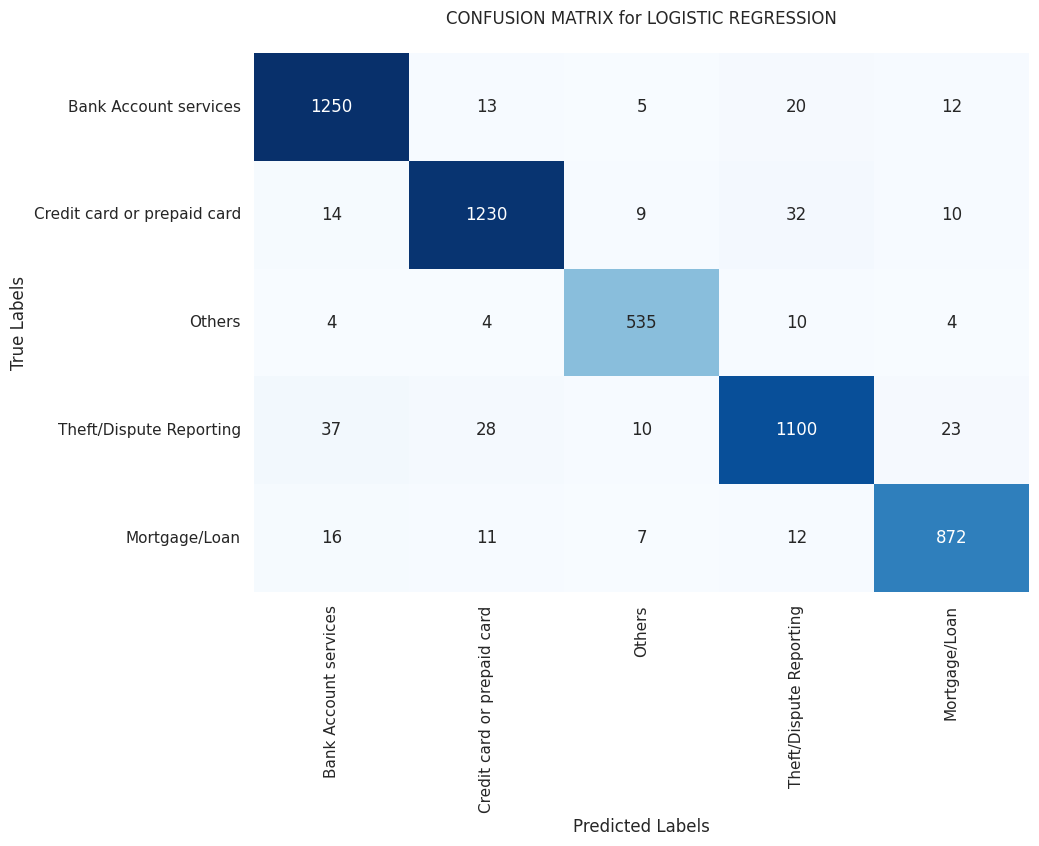

In [182]:
model_evaluation(y_test, y_pred_lr_tuned, model_name)

In [183]:
f1_summary_table = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.95


**Model:2 - Decision Tree**

In [184]:
from sklearn.tree import DecisionTreeClassifier
model_name = 'Decision Tree'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [185]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10}


In [186]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=10,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [187]:
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.796870579153213

CLASSIFICATION REPORT for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.81      0.84      0.82      1300
Credit card or prepaid card       0.82      0.84      0.83      1295
                     Others       0.78      0.75      0.76       557
    Theft/Dispute Reporting       0.76      0.71      0.74      1198
              Mortgage/Loan       0.81      0.83      0.82       918

                   accuracy                           0.80      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.80      0.80      0.80      5268



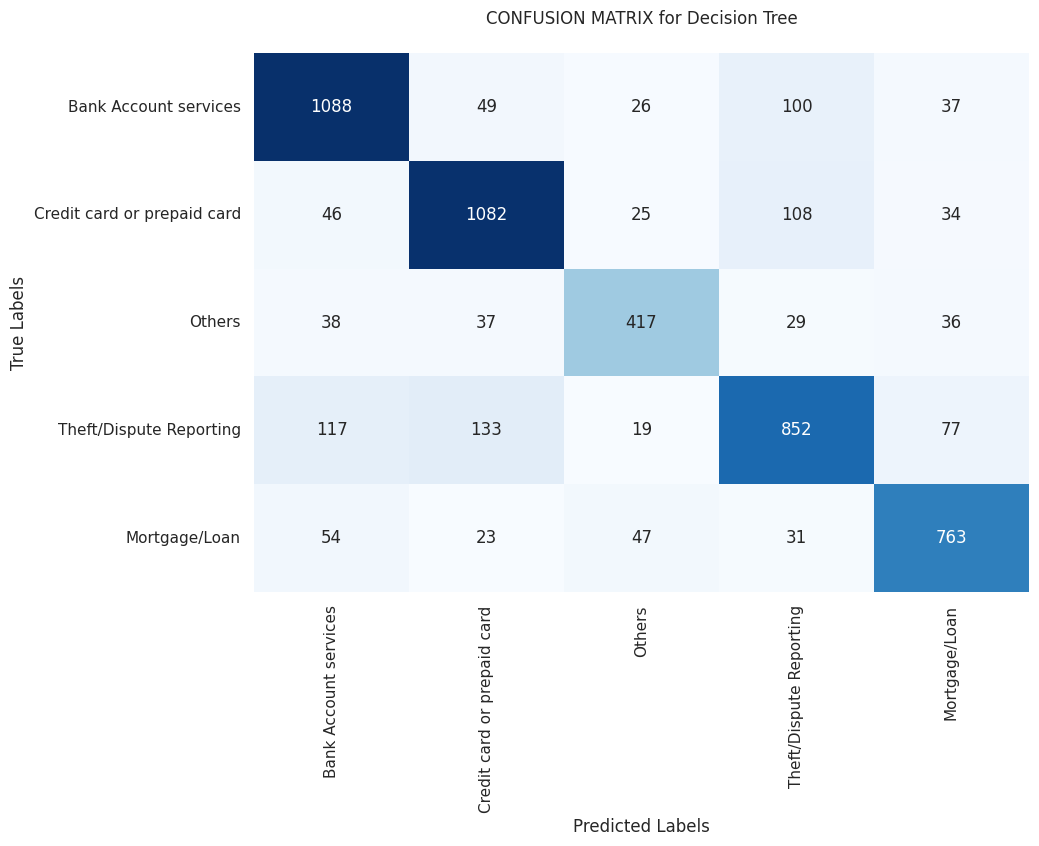

In [188]:
model_evaluation(y_test, y_pred_dt_tuned, model_name)

In [189]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.95
1,Decision Tree,0.80


In [190]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

**Model:3 - Random Forest**

In [193]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'Random Forest'
rf_cfl = RandomForestClassifier(n_estimators=200,
                                 max_features='sqrt',
                                 min_samples_leaf=5,
                                 min_samples_split=6,
                                 n_jobs=-1,
                                 random_state=42)

rf_cfl.fit(X_train, y_train)
y_pred_rf = rf_cfl.predict(X_test)


In [194]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8059133086230783

CLASSIFICATION REPORT for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.93      0.85      1300
Credit card or prepaid card       0.79      0.87      0.83      1295
                     Others       0.95      0.38      0.54       557
    Theft/Dispute Reporting       0.82      0.80      0.81      1198
              Mortgage/Loan       0.86      0.86      0.86       918

                   accuracy                           0.82      5268
                  macro avg       0.84      0.77      0.78      5268
               weighted avg       0.83      0.82      0.81      5268



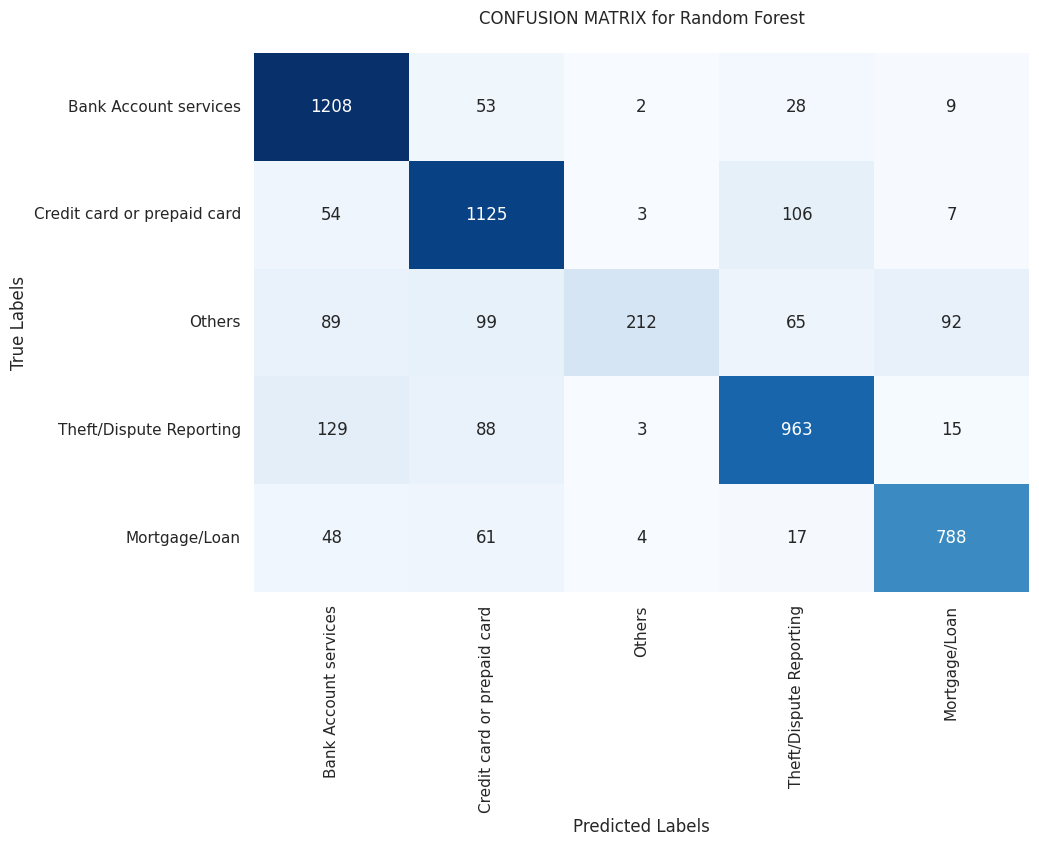

In [195]:
model_evaluation(y_test, y_pred_rf, model_name)

In [196]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Random Forest', round(f1_rf, 2)]
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.95
1,Decision Tree,0.80
2,Random Forest,0.81


**Model:4 - Naive Bayes**

In [197]:
from sklearn.naive_bayes import MultinomialNB
model_name = 'Naive Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [198]:
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb,
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [199]:
model_name = 'Naive Bayes'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [200]:
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7796193195018605

CLASSIFICATION REPORT for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1300
Credit card or prepaid card       0.81      0.75      0.78      1295
                     Others       0.66      0.65      0.66       557
    Theft/Dispute Reporting       0.77      0.77      0.77      1198
              Mortgage/Loan       0.83      0.85      0.84       918

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



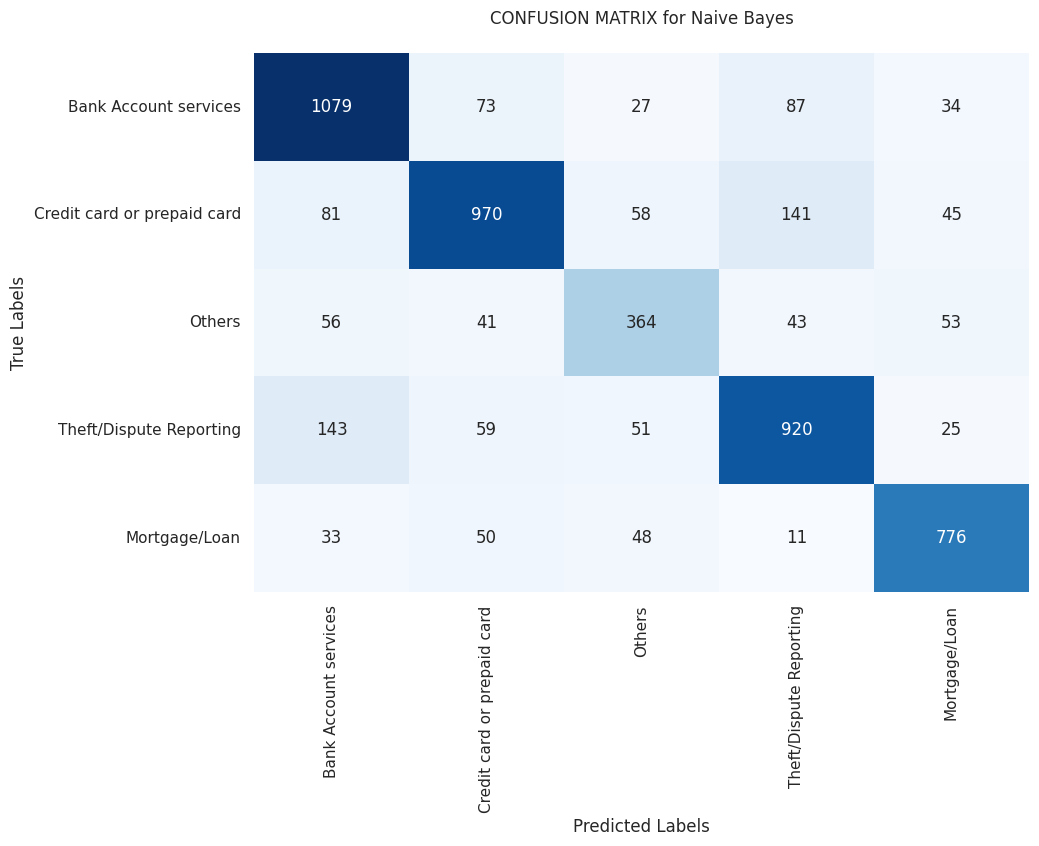

In [201]:
model_evaluation(y_test, y_pred_nb_tuned, model_name)

In [202]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Naive Bayes', round(f1_nb, 2)]
f1_summary_table


,Model,F1 Score
0,Logistic Regression,0.95
1,Decision Tree,0.80
2,Random Forest,0.81
3,Naive Bayes,0.78


**Based on our analysis of all four models, Logistic Regression has demonstrated the best performance. Therefore, we will evaluate the model's performance using custom text inputs.**

In [203]:
def topic_predicter(text):

    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [215]:
df_custom_complaints = pd.DataFrame({'complaints': ["How I can take a Loan through mortaging my assets ?",
                                  "Would you please share me Branch info in Gulshan ?",
                                  "In my last statement, I have observed some disputes in the Bill. Please let me know how I can resolve the issue.",
                                  "While doing transaction in latest payment, money has been deducted twice. Please take the necessary precaution",
                                  "I want to change my credit card bill date. Please let me know the process"
                                  ]})
df_custom_complaints

,complaints
0,How I can take a Loan through mortaging my ass...
1,Would you please share me Branch info in Gulsh...
2,"In my last statement, I have observed some dis..."
3,"While doing transaction in latest payment, mon..."
4,I want to change my credit card bill date. Ple...


In [216]:
df_custom_complaints['predicted topic'] = df_custom_complaints['complaints'].apply(lambda x: topic_predicter([x]))
df_custom_complaints

,complaints,predicted topic
0,How I can take a Loan through mortaging my ass...,Mortgage/Loan
1,Would you please share me Branch info in Gulsh...,Bank Account services
2,"In my last statement, I have observed some dis...",Theft/Dispute Reporting
3,"While doing transaction in latest payment, mon...",Others
4,I want to change my credit card bill date. Ple...,Credit card or prepaid card
